# Figures for Yeager et al., 2025: Efficient Drift Correction of Initialized Earth System Predictions
### CESM2-S2S analysis

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
import os
import nc_time_axis
%matplotlib inline

# import plotting and other utilities
# https://github.com/sgyeager/mypyutils
from mypyutils import calendar_utils as cal
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import regrid_utils as regrid
from mypyutils import io_utils as io
from mypyutils import stat_utils as stat

### Create Dask Cluster

In [36]:
try:
    client.shutdown()
except:
    pass

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='32GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=32GB',
        account='P06010014',
        walltime='02:30:00',
        local_directory='/glade/derecho/scratch/yeager/',
        log_directory='/glade/derecho/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": 1.0,
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 
client

<Client: 'tcp://128.117.208.196:36475' processes=0 threads=0, memory=0 B>

### Read in processed CESM2-S2S Data

In [3]:
fdir = '/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/forYeager/climoTest/'
ds_tas_em = xr.open_dataset(fdir+'tas_2m_cesm2cam6_caseStudies_allLeads_EM_new.nc').rename({'data':'tas'})
ds_tas_em['tas'] = ds_tas_em['tas'] - 272.15
ds_tas = xr.open_dataset(fdir+'/tas_2m_cesm2cam6_caseStudies_allLeads_allMembers_new.nc').rename({'data':'tas'})
ds_tas['tas'] = ds_tas['tas'] - 272.15
ds_tas_climoIC_em = xr.open_dataset(fdir+'tas_2m_cesm2cam6climoALLyeager_allLeads_EM_new.nc').rename({'data':'tas'})
ds_tas_climoIC_em['tas'] = ds_tas_climoIC_em['tas'] - 272.15
tas_climoIC_feb = xr.open_dataset(fdir+'tas_2m_cesm2cam6climoALLyeager_allLeads_allMembers_Feb_new.nc').rename({'data':'tas'}).isel(init=7)
tas_climoIC_feb['tas'] = tas_climoIC_feb['tas']- 272.15
tas_climoIC_jun = xr.open_dataset(fdir+'tas_2m_cesm2cam6climoALLyeager_allLeads_allMembers_June_new.nc').rename({'data':'tas'}).isel(init=20)
tas_climoIC_jun['tas'] = tas_climoIC_jun['tas']- 272.15

In [5]:
initime=ds_tas.init
febic = initime.where(initime.dt.month==2).dropna('init',how='all')
junic = initime.where(initime.dt.month==6).dropna('init',how='all')
tas_feb8 = ds_tas.sel(init=febic)
tas_jun21 = ds_tas.sel(init=junic)

In [6]:
initime=ds_tas_em.init
febic = initime.where(initime.dt.month==2).dropna('init',how='all')
junic = initime.where(initime.dt.month==6).dropna('init',how='all')
tas_feb8_em = ds_tas_em.sel(init=febic)
tas_jun21_em = ds_tas_em.sel(init=junic)

In [7]:
tas_climo2_feb8_em = tas_feb8_em.mean('init')
tas_climo2_jun21_em = tas_jun21_em.mean('init')
tas_climo2_feb8 = tas_feb8.mean('init')
tas_climo2_jun21 = tas_jun21.mean('init')

In [8]:
sampy1 = [1999,2003,2007,2011,2015,2019]
sampy2 = [1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019]
sel1 = tas_feb8_em.init.dt.year.isin(sampy1)
tas_climo2_6init_feb8 = tas_feb8_em.isel(init=sel1).mean('init')
sel2 = tas_feb8_em.init.dt.year.isin(sampy2)
tas_climo2_11init_feb8 = tas_feb8_em.isel(init=sel2).mean('init')
sel1 = tas_jun21_em.init.dt.year.isin(sampy1)
tas_climo2_6init_jun21 = tas_jun21_em.isel(init=sel1).mean('init')
sel2 = tas_jun21_em.init.dt.year.isin(sampy2)
tas_climo2_11init_jun21 = tas_jun21_em.isel(init=sel2).mean('init')

In [9]:
dates = [cftime.DatetimeNoLeap(2010, 2, 8, 0, 0, 0, 0, has_year_zero=True),cftime.DatetimeNoLeap(2010, 6, 21, 0, 0, 0, 0, has_year_zero=True)]
tas_climoic_feb8_em = ds_tas_climoIC_em.sel(init=dates[0])
tas_climoic_jun21_em = ds_tas_climoIC_em.sel(init=dates[1])

In [11]:
def weekly_average(ds,var):
    weeks = {1: 0, 2: 7, 3: 14, 4: 21, 5: 28, 6: 35}
    timeunits = 'days since 1999-01-01'
    weekly_mean = lambda da, start: da.isel(time=slice(start, start + 7)).mean(dim="time")
    for wk, start in weeks.items():
        ds[f"{var}{wk}"] = weekly_mean(ds[var], start)
    return ds

In [12]:
tas_feb8_wk = weekly_average(tas_feb8,'tas')
tas_jun21_wk = weekly_average(tas_jun21,'tas')
tas_climo2_feb8_wk = weekly_average(tas_climo2_feb8_em,'tas')
tas_climo2_jun21_wk = weekly_average(tas_climo2_jun21_em,'tas')
tas_climoic_feb8_wk = weekly_average(tas_climoic_feb8_em,'tas')
tas_climoic_jun21_wk = weekly_average(tas_climoic_jun21_em,'tas')

In [13]:
tas_climo2_6init_feb8_wk = weekly_average(tas_climo2_6init_feb8,'tas')
tas_climo2_6init_jun21_wk = weekly_average(tas_climo2_6init_jun21,'tas')
tas_climo2_11init_feb8_wk = weekly_average(tas_climo2_11init_feb8,'tas')
tas_climo2_11init_jun21_wk = weekly_average(tas_climo2_11init_jun21,'tas')

### Get TAS OBS

In [15]:
tas_cpc_clim = xr.open_dataset('/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/tas_2m_clim_CPC_data.nc').rename({'clim':'tas'})

In [16]:
# compute weekly average observed climatology for each case
tas_climocpc_feb8 = tas_cpc_clim.sel(time=slice(39,39+45))
tas_climocpc_feb8_wk = weekly_average(tas_climocpc_feb8,'tas')
tas_climocpc_jun21 = tas_cpc_clim.sel(time=slice(172,172+45))
tas_climocpc_jun21_wk = weekly_average(tas_climocpc_jun21,'tas')

### Create resampled 1-member and 3-member arrays

In [17]:
# Create a member variable for this ds to check that resample works as intended:
member = tas_feb8_wk['member'].broadcast_like(tas_feb8_wk['init'])
tas_feb8_wk['mymember'] = member

In [19]:
%%time
iterations = 100
tas_feb8_wk_resamp1 = stat.resamp(tas_feb8_wk.drop_vars(['tas']),'member','init',1,iterations)
tas_feb8_wk_resamp3 = stat.resamp(tas_feb8_wk.drop_vars(['tas']),'member','init',3,iterations)

CPU times: user 14.9 s, sys: 3.79 s, total: 18.6 s
Wall time: 20 s


In [21]:
%%time
iterations = 100
tas_jun21_wk_resamp1 = stat.resamp(tas_jun21_wk.drop_vars(['tas']),'member','init',1,iterations)
tas_jun21_wk_resamp3 = stat.resamp(tas_jun21_wk.drop_vars(['tas']),'member','init',3,iterations)

CPU times: user 14.8 s, sys: 3.22 s, total: 18 s
Wall time: 19.8 s


## Latlon ClimoBias Comparison Plot

In [22]:
%%time
tas_climobias2_feb8 = tas_climo2_feb8_wk.drop_vars('tas') - tas_climocpc_feb8_wk.drop_vars('tas')
tas_climobias2_jun21 = tas_climo2_jun21_wk.drop_vars('tas') - tas_climocpc_jun21_wk.drop_vars('tas')

CPU times: user 18.3 ms, sys: 0 ns, total: 18.3 ms
Wall time: 172 ms


In [23]:
%%time
tas_climobias2_feb8_allmem = tas_feb8_wk.drop_vars('tas').mean('init') - tas_climocpc_feb8_wk.drop_vars('tas')
tas_climobias2_jun21_allmem = tas_jun21_wk.drop_vars('tas').mean('init') - tas_climocpc_jun21_wk.drop_vars('tas')

CPU times: user 151 ms, sys: 491 μs, total: 151 ms
Wall time: 155 ms


In [24]:
%%time
tas_climobias2_feb8_1mem = tas_feb8_wk_resamp1.mean('init') - tas_climocpc_feb8_wk.drop_vars('tas')
tas_climobias2_feb8_1mem = tas_climobias2_feb8_1mem.load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 3.21 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2.85 s, sys: 1.75 s, total: 4.6 s
Wall time: 16 s


In [25]:
%%time
tas_climobias2_feb8_3mem = tas_feb8_wk_resamp3.mean('init') - tas_climocpc_feb8_wk.drop_vars('tas')
tas_climobias2_feb8_3mem = tas_climobias2_feb8_3mem.load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 9.62 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1.16 s, sys: 4.01 s, total: 5.17 s
Wall time: 5.79 s


In [26]:
%%time
tas_climobias2_6init_feb8 = tas_climo2_6init_feb8_wk.drop_vars('tas') - tas_climocpc_feb8_wk.drop_vars('tas')
tas_climobias2_6init_jun21 = tas_climo2_6init_jun21_wk.drop_vars('tas') - tas_climocpc_jun21_wk.drop_vars('tas')

CPU times: user 6.03 ms, sys: 766 μs, total: 6.8 ms
Wall time: 7.5 ms


In [27]:
%%time
tas_climobias2_11init_feb8 = tas_climo2_11init_feb8_wk.drop_vars('tas') - tas_climocpc_feb8_wk.drop_vars('tas')
tas_climobias2_11init_jun21 = tas_climo2_11init_jun21_wk.drop_vars('tas') - tas_climocpc_jun21_wk.drop_vars('tas')

CPU times: user 3.63 ms, sys: 0 ns, total: 3.63 ms
Wall time: 3.64 ms


In [30]:
%%time
tas_climobias3_feb8 = tas_climoic_feb8_wk.drop_vars('tas') - tas_climocpc_feb8_wk.drop_vars('tas')
tas_climobias3_jun21 = tas_climoic_jun21_wk.drop_vars('tas') - tas_climocpc_jun21_wk.drop_vars('tas')

CPU times: user 2.89 ms, sys: 0 ns, total: 2.89 ms
Wall time: 2.89 ms


In [31]:
%%time
tas_climobias2_jun21_1mem = tas_jun21_wk_resamp1.mean('init') - tas_climocpc_jun21_wk.drop_vars('tas')
tas_climobias2_jun21_1mem = tas_climobias2_jun21_1mem.load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 3.21 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 944 ms, sys: 991 ms, total: 1.94 s
Wall time: 2.23 s


In [32]:
%%time
tas_climobias2_jun21_3mem = tas_jun21_wk_resamp3.mean('init') - tas_climocpc_jun21_wk.drop_vars('tas')
tas_climobias2_jun21_3mem = tas_climobias2_jun21_3mem.load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 9.62 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1.05 s, sys: 3.19 s, total: 4.25 s
Wall time: 4.74 s


## Figure 1

CPU times: user 2.3 s, sys: 39.8 ms, total: 2.34 s
Wall time: 2.94 s


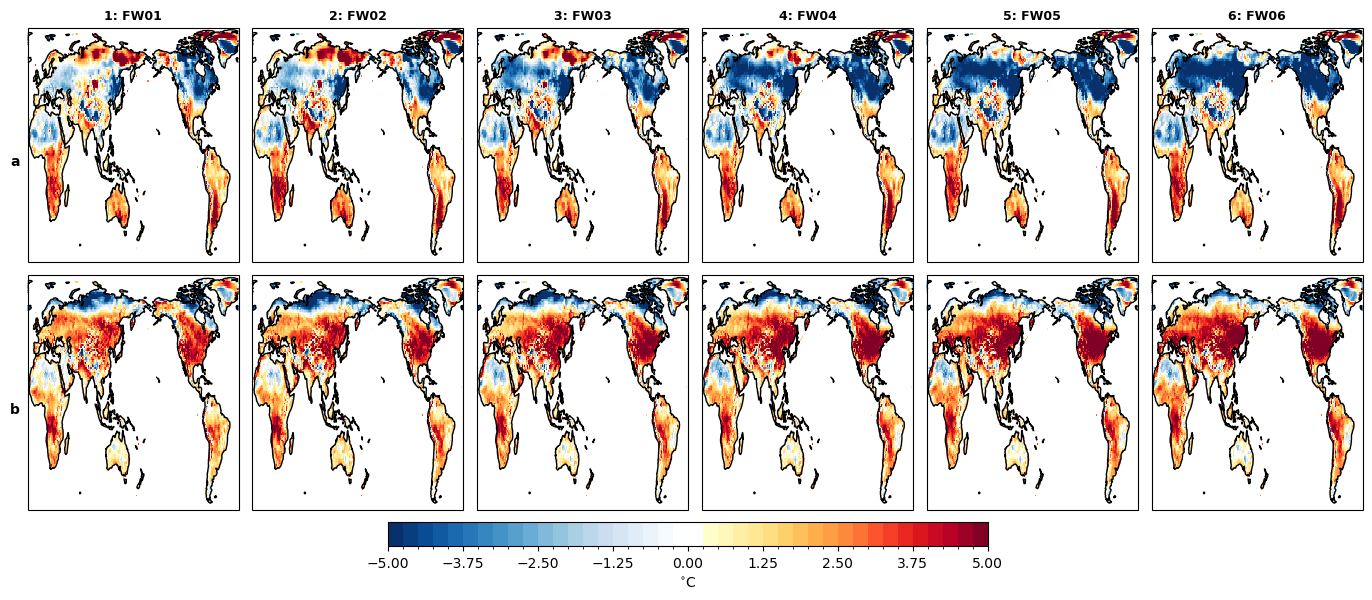

In [29]:
%%time

ci = 0.25
cmin = -5
cmax = 5

fig = plt.figure(figsize=(15,6))
nrows=2
ncols=6

proj = ccrs.PlateCarree(central_longitude=160)

fsize=10
fweight='bold'
cmap = "blue2red"
lon = tas_climobias2_feb8.lon
lat = tas_climobias2_feb8.lat

for i in range(ncols):
    var = 'tas{}'.format(i+1)
    titstr = '{}: FW'.format(i+1)+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tas_climobias2_feb8[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(titstr,loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    ax1.set_ylim([-60,85])

for i in range(ncols):
    var = 'tas{}'.format(i+1)
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, tas_climobias2_jun21[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax3.text(-210,0,'b',fontsize=10,weight='bold')
    ax3.set_ylim([-60,85])




fig.tight_layout()
fig.subplots_adjust(bottom=0.14,left=0.1)
cbar_ax = fig.add_axes([0.34, 0.08, 0.4, 0.04])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig01.png')

## Figure 2

In [33]:
def add_box(ax,lonlat):
    clr='red'
    x0 = lonlat.values[0]; x1 = lonlat.values[1]; y0 = lonlat.values[2]; y1 = lonlat.values[3]
    if ((x0>0) and (x1<0)):
        ax.plot(np.linspace(x0,x0,20), np.linspace(y0,y1,20), color=clr,transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x1,x1,20), np.linspace(y0,y1,20), color=clr,transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,180,20), np.linspace(y0,y0,20), color=clr,transform=ccrs.PlateCarree())
        ax.plot(np.linspace(-180,x1,20), np.linspace(y0,y0,20), color=clr,transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,180,20), np.linspace(y1,y1,20), color=clr,transform=ccrs.PlateCarree())
        ax.plot(np.linspace(-180,x1,20), np.linspace(y1,y1,20), color=clr,transform=ccrs.PlateCarree())
    else:
        ax.plot(np.linspace(x0,x0,20), np.linspace(y0,y1,20), color=clr,transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x1,x1,20), np.linspace(y0,y1,20), color=clr,transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,x1,20), np.linspace(y0,y0,20), color=clr,transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,x1,20), np.linspace(y1,y1,20), color=clr,transform=ccrs.PlateCarree())

In [34]:
reglonlat = [[360-120.,360-90.,50.,60.]
            ]
regstr = ['Canada']
regions1 = xr.DataArray(reglonlat,
                       dims=["region", "lonlat"],
                       coords=[("region",regstr),("lonlat",['lon0','lon1','lat0','lat1'])]
                      )
nregion1 = regions1.region.size

In [35]:
regions1.isel(region=0).values[0]

np.float64(240.0)

CPU times: user 3.47 s, sys: 39.4 ms, total: 3.51 s
Wall time: 3.88 s


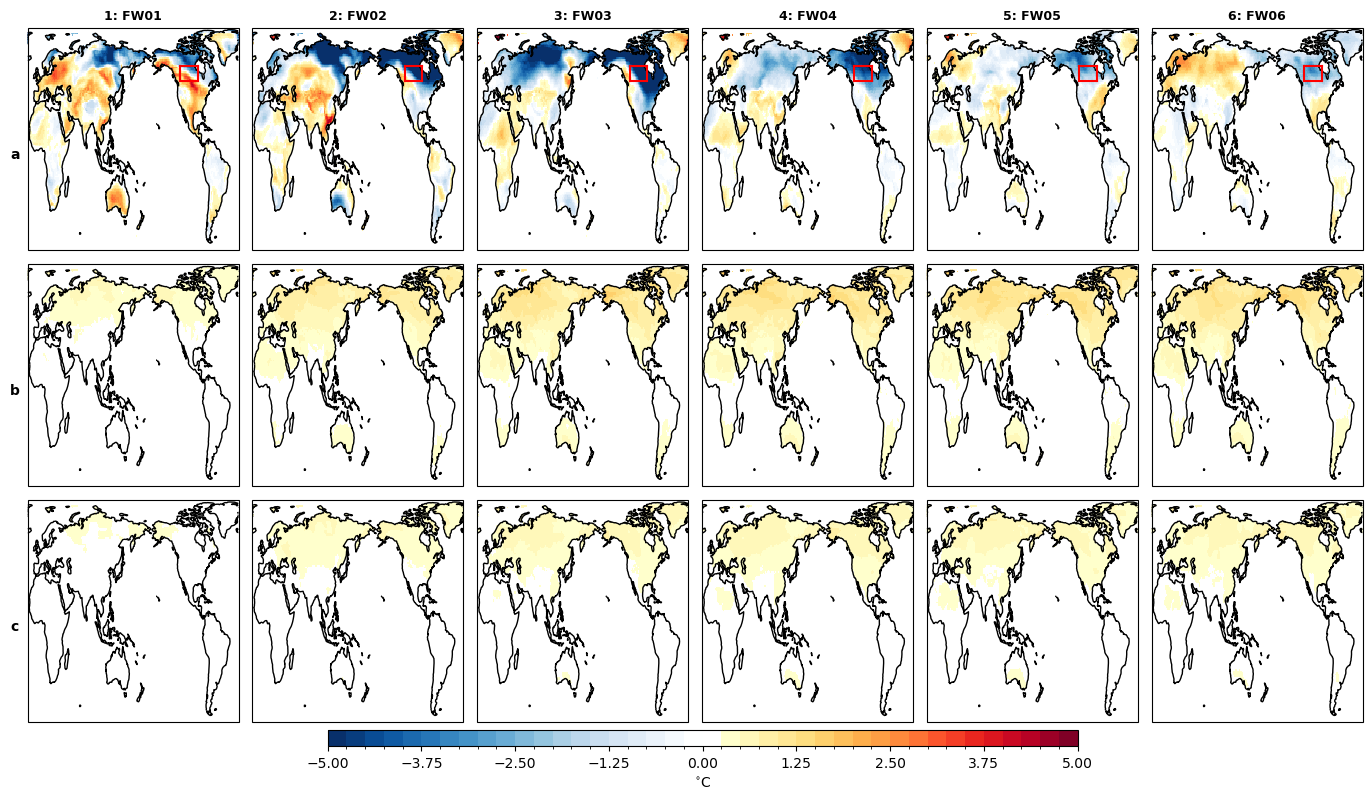

In [34]:
%%time

ci = 0.25
cmin = -5
cmax = 5

fig = plt.figure(figsize=(15,8))
nrows=3
ncols=6

proj = ccrs.PlateCarree(central_longitude=160)

fsize=10
fweight='bold'
cmap = "blue2red"
lon = tas_climobias2_feb8.lon
lat = tas_climobias2_feb8.lat

tmp = tas_climobias3_feb8 - tas_climobias2_feb8
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    titstr = '{}: FW'.format(i+1)+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(titstr,loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    ax1.set_ylim([-60,85])
    for r in range(nregion1):
        add_box(ax1,regions1.isel(region=r))

tmp = (tas_climobias2_feb8_1mem.isel(member=0) - tas_climobias2_feb8).std('iteration')
#tmp = tas_climobias2_feb8_allmem_resamp1.isel(iteration=12).isel(member=0) - tas_climobias2_feb8
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, tmp[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1*ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax3.text(-210,0,'b',fontsize=10,weight='bold')
    ax3.set_ylim([-60,85])


#tmp = tas_climobias2_feb8_allmem.isel(member=slice(0,3)).mean('member') - tas_climobias2_feb8
tmp = (tas_climobias2_feb8_3mem.mean('member') - tas_climobias2_feb8).std('iteration')
#tmp = tas_climobias3_jun21
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    leadstr = 'FW '+str(i+1).zfill(2)
    labstr = 'd'+str(i+1).zfill(2)
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, tmp[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+2*ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax4.text(-210,0,'c',fontsize=10,weight='bold')
    ax4.set_ylim([-60,85])



fig.tight_layout()
fig.subplots_adjust(bottom=0.09,left=0.1)
cbar_ax = fig.add_axes([0.3, 0.06, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig02.png')

## Supplementary Figure 2

CPU times: user 1.98 s, sys: 3.53 ms, total: 1.99 s
Wall time: 2.1 s


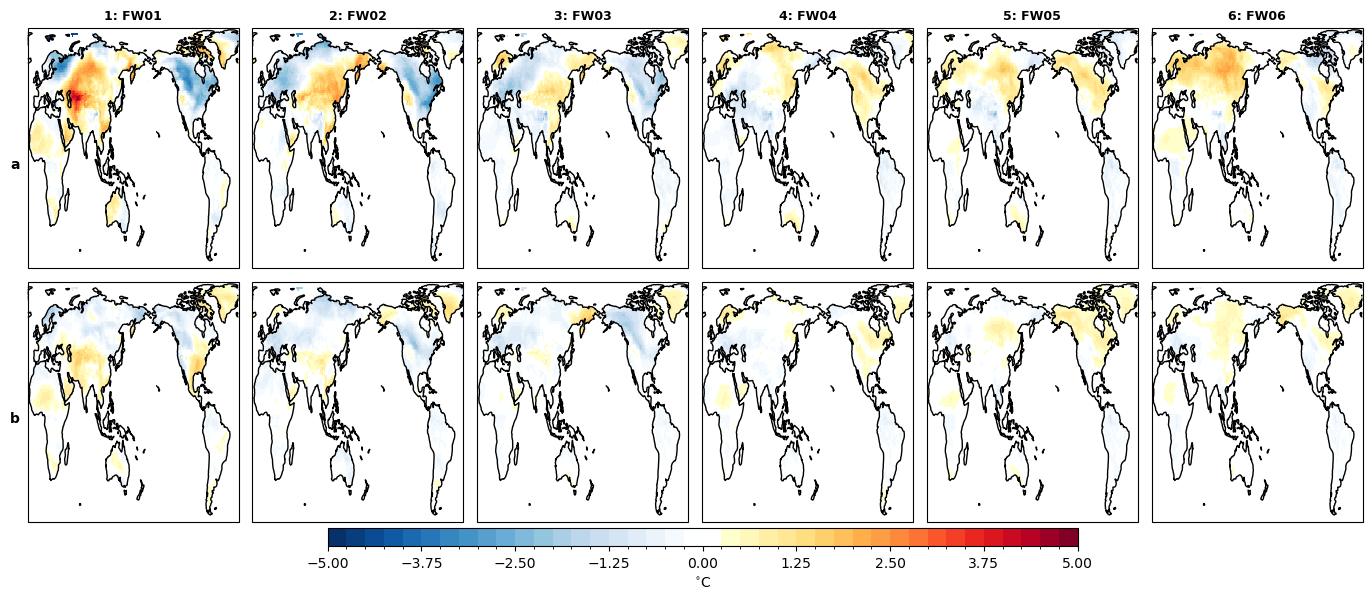

In [37]:
%%time

ci = 0.25
cmin = -5
cmax = 5

fig = plt.figure(figsize=(15,6))
nrows=2
ncols=6

proj = ccrs.PlateCarree(central_longitude=160)

fsize=10
fweight='bold'
cmap = "blue2red"
lon = tas_climobias2_feb8.lon
lat = tas_climobias2_feb8.lat

tmp = tas_climobias2_6init_feb8 - tas_climobias2_feb8
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    titstr = '{}: FW'.format(i+1)+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(titstr,loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    ax1.set_ylim([-60,85])

tmp = tas_climobias2_11init_feb8 - tas_climobias2_feb8
#tmp = tas_climobias3_feb8
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, tmp[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax2.text(-210,0,'b',fontsize=10,weight='bold')
    ax2.set_ylim([-60,85])


fig.tight_layout()
fig.subplots_adjust(bottom=0.12,left=0.1)
#cbar_ax = fig.add_axes([0.3, 0.02, 0.5, 0.04])
cbar_ax = fig.add_axes([0.3, 0.08, 0.5, 0.03])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig_supp02.png')

## Figure 3

CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 4.07 s


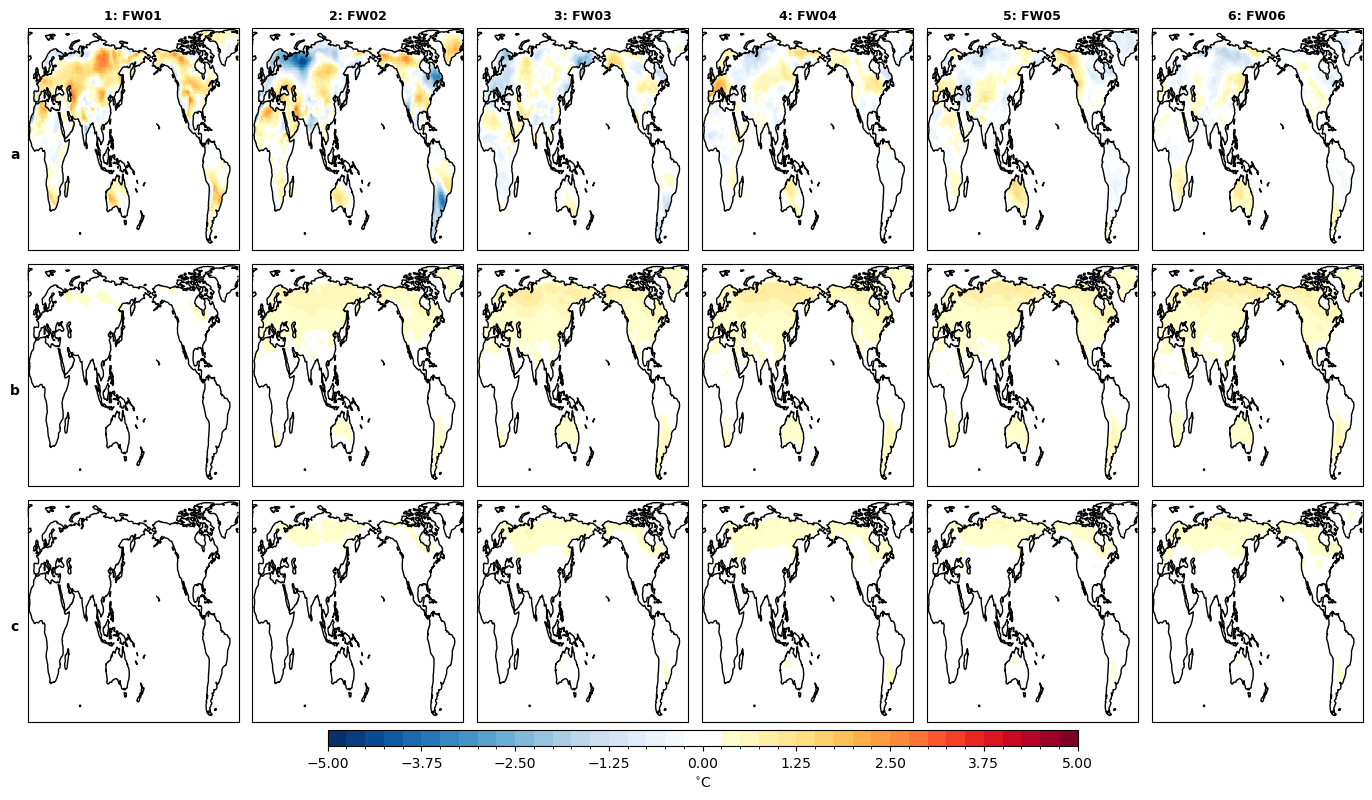

In [38]:
%%time

ci = 0.25
cmin = -5
cmax = 5

fig = plt.figure(figsize=(15,8))
nrows=3
ncols=6

proj = ccrs.PlateCarree(central_longitude=160)

fsize=10
fweight='bold'
cmap = "blue2red"
lon = tas_climobias2_jun21.lon
lat = tas_climobias2_jun21.lat

tmp = tas_climobias3_jun21 - tas_climobias2_jun21
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    titstr = '{}: FW'.format(i+1)+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(titstr,loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    ax1.set_ylim([-60,85])

#tmp = tas_climobias2_jun21_allmem.isel(member=slice(0,1)).mean('member') - tas_climobias2_jun21
tmp = (tas_climobias2_jun21_1mem.isel(member=0) - tas_climobias2_jun21).std('iteration')
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, tmp[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1*ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax3.text(-210,0,'b',fontsize=10,weight='bold')
    ax3.set_ylim([-60,85])


#tmp = tas_climobias2_jun21_allmem.isel(member=slice(0,3)).mean('member') - tas_climobias2_jun21
tmp = (tas_climobias2_jun21_3mem.mean('member') - tas_climobias2_jun21).std('iteration')
#tmp = tas_climobias3_jun21
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    leadstr = 'FW '+str(i+1).zfill(2)
    labstr = 'c'+str(i+1).zfill(2)
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, tmp[var], lon, lat,ci,cmin,cmax,'',nrows,ncols,i+2*ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax4.text(-210,0,'c',fontsize=10,weight='bold')
    ax4.set_ylim([-60,85])



fig.tight_layout()
fig.subplots_adjust(bottom=0.09,left=0.1)
cbar_ax = fig.add_axes([0.3, 0.06, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig03.png')

## Regional SAT

In [49]:
def reg_avg(ds,wgt,region):
    tmp_ds = ds.sel(lon=slice(region[0],region[1])).sel(lat=slice(region[2],region[3]))
    tmp_wgt = wgt.sel(lat=slice(region[2],region[3]))
    ds_out = tmp_ds.weighted(tmp_wgt).mean(['lat','lon'])
    return ds_out

In [50]:
coswgts = np.cos(np.deg2rad(ds_tas.lat))

In [51]:
reglonlat = regions1.isel(region=0)
tas_feb8_reg = reg_avg(tas_feb8['tas'],coswgts,reglonlat)
tas_climo_feb8_reg = reg_avg(tas_climo2_feb8['tas'],coswgts,reglonlat)
tas_climoic_feb8_em_reg = reg_avg(tas_climoic_feb8_em['tas'],coswgts,reglonlat)
tas_climoic_feb8_reg = reg_avg(tas_climoIC_feb['tas'],coswgts,reglonlat)
tas_climocpc_feb8_reg = reg_avg(tas_climocpc_feb8['tas'],coswgts,reglonlat)
tas_climosasha_feb8_reg = reg_avg(tas_climo2sm_feb8['tas'],coswgts,reglonlat)

In [52]:
tas_jun21_reg = reg_avg(tas_jun21['tas'],coswgts,reglonlat)
tas_climo_jun21_reg = reg_avg(tas_climo2_jun21['tas'],coswgts,reglonlat)
tas_climoic_jun21_em_reg = reg_avg(tas_climoic_jun21_em['tas'],coswgts,reglonlat)
tas_climoic_jun21_reg = reg_avg(tas_climoIC_jun['tas'],coswgts,reglonlat)
tas_climocpc_jun21_reg = reg_avg(tas_climocpc_jun21['tas'],coswgts,reglonlat)
tas_climosasha_jun21_reg = reg_avg(tas_climo2sm_jun21['tas'],coswgts,reglonlat)

## Figure 4

In [53]:
iterations = 100
tas_feb8_reg_resamp = stat.resamp(tas_feb8_reg, 'member','init',1,iterations)
tas_jun21_reg_resamp = stat.resamp(tas_jun21_reg, 'member','init',1,iterations)

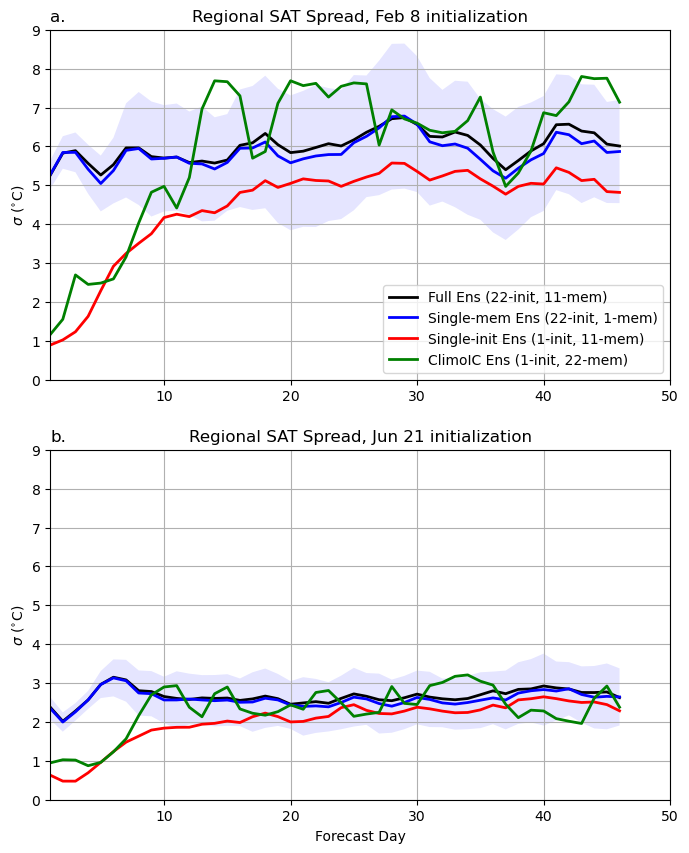

In [54]:
fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

time = tas_climo_feb8_reg.time
nmemsub = 3
initind = 5

ax1.plot(time,tas_feb8_reg.std(['init','member']),color='k',lw=2,label='Full Ens (22-init, 11-mem)')
#tmp = tas_feb8_reg.std(['init']).mean('member')
tmp = tas_feb8_reg_resamp.std(['init']).mean('iteration').isel(member=0)
ax1.plot(time,tmp,color='b',lw=2,label='Single-mem Ens (22-init, 1-mem)')
#low = tas_feb8_reg_resamp.std('init').quantile([0.05],dim='iteration').squeeze()
#high = tas_feb8_reg_resamp.std('init').quantile([0.95],dim='iteration').squeeze()
tmp_sd = tas_feb8_reg_resamp.std('init').std('iteration').isel(member=0)
low = tmp-2*tmp_sd
high = tmp+2*tmp_sd
ax1.fill_between(time,low,high,fc='blue',alpha=0.1)
tmp = tas_feb8_reg.std(['member']).mean('init')
tmp2 = tas_feb8_reg.std(['member']).std('init')
low = tmp-2*tmp2
high = tmp+2*tmp2
ax1.plot(time,tmp,color='r',lw=2,label='Single-init Ens (1-init, 11-mem)')
#ax1.fill_between(time,low,high,fc='red',alpha=0.1)
ax1.plot(time,tas_climoic_feb8_reg.std('member'),color='g',lw=2,label='ClimoIC Ens (1-init, 22-mem)')

ax1.set_ylabel(r'$\sigma\ (^{\circ}$C)')
#ax1.set_xlabel('Forecast Day')
ax1.set_ylim(0,9)
ax1.set_xlim(1,50)
ax1.legend(loc='lower right')
ax1.set_title('a.',loc='left')
ax1.set_title('Regional SAT Spread, Feb 8 initialization',loc='center')
ax1.grid()

time = tas_climo_jun21_reg.time

ax2.plot(time,tas_jun21_reg.std(['init','member']),color='k',lw=2,label='Full Ens (22-init, 11-mem)')
tmp = tas_jun21_reg_resamp.std(['init']).mean('iteration').isel(member=0)
#tmp = tas_jun21_reg.std(['init']).mean('member')
ax2.plot(time,tmp,color='b',lw=2,label='Single-mem Ens (22-init, 1-mem)')
tmp_sd = tas_jun21_reg_resamp.std('init').std('iteration').isel(member=0)
low = tmp-2*tmp_sd
high = tmp+2*tmp_sd
#low = tas_jun21_reg_resamp.std('init').quantile([0.05],dim='iteration').squeeze()
#high = tas_jun21_reg_resamp.std('init').quantile([0.95],dim='iteration').squeeze()
ax2.fill_between(time,low,high,fc='blue',alpha=0.1)
tmp = tas_jun21_reg.std(['member']).mean('init')
tmp2 = tas_jun21_reg.std(['member']).std('init')
low = tmp-2*tmp2
high = tmp+2*tmp2
ax2.plot(time,tmp,color='r',lw=2,label='Single-init Ens (1-init, 11-mem)')
#ax2.fill_between(time,low,high,fc='red',alpha=0.1)
ax2.plot(time,tas_climoic_jun21_reg.std('member'),color='g',lw=2,label='ClimoIC Ens (1-init, 22-mem)')
ax2.set_ylabel(r'$\sigma\ (^{\circ}$C)')
ax2.set_xlabel('Forecast Day')
ax2.set_ylim(0,9)
ax2.set_xlim(1,50)
#ax2.legend(loc='lower right')
ax2.set_title('b.',loc='left')
ax2.set_title('Regional SAT Spread, Jun 21 initialization',loc='center')
ax2.grid()

plt.savefig('Fig04.png')

## Figure 5

In [39]:
lvalsda = xr.DataArray(np.arange(6,dtype='int')+1,dims="L",name="L")
landmask = xr.where(tas_climocpc_feb8_wk['tas1'].isnull(),0,1)

In [40]:
%%time
tmp = tas_feb8_wk.rename({'member':'M'}).drop_vars('tas') - tas_climo2_feb8_wk.drop_vars('tas')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom2_feb8_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 45.7 ms, sys: 220 μs, total: 45.9 ms
Wall time: 47.7 ms


In [41]:
%%time
tmp = tas_feb8_wk.rename({'member':'M'}).drop_vars('tas') - tas_climocpc_feb8_wk.drop_vars('tas')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom1_feb8_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 119 ms


In [42]:
%%time
tmp = tas_feb8_wk.rename({'member':'M'}).drop_vars('tas') - tas_climoic_feb8_wk.drop_vars(['tas','date'])
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom3_feb8_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 40.8 ms, sys: 3.49 ms, total: 44.3 ms
Wall time: 46 ms


In [43]:
%%time
tmp = tas_feb8_wk.rename({'member':'M'}).drop_vars('tas') - tas_climo2sm_feb8_wk.drop_vars('tas')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom2sm_feb8_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 40.7 ms, sys: 74 μs, total: 40.8 ms
Wall time: 40.8 ms


In [47]:
%%time
tmp = tas_feb8_wk.rename({'member':'M'}).drop_vars('tas')  - tas_feb8_wk_resamp1.isel(member=0).drop_vars(['date']).mean('init')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom2_1mem_feb8_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 452 ms, sys: 2.79 ms, total: 455 ms
Wall time: 534 ms


In [48]:
%%time
tmp = tas_feb8_wk.rename({'member':'M'}).drop_vars('tas') - tas_feb8_wk_resamp3.mean('member').drop_vars(['date']).mean('init')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom2_3mem_feb8_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 454 ms, sys: 4.48 ms, total: 459 ms
Wall time: 467 ms


In [50]:
%%time
msss3_feb8 = stat.compute_skillcompare_monthly(tas_anom3_feb8_wk,tas_anom2_feb8_wk,nleads=6,resamp=0,detrend=False)['msss'].load()
msss1_feb8 = stat.compute_skillcompare_monthly(tas_anom1_feb8_wk,tas_anom2_feb8_wk,nleads=6,resamp=0,detrend=False)['msss'].load()
msss2sm_feb8 = stat.compute_skillcompare_monthly(tas_anom2sm_feb8_wk,tas_anom2_feb8_wk,nleads=6,resamp=0,detrend=False)['msss'].load()
msss2_1mem_feb8 = stat.compute_skillcompare_monthly(tas_anom2_1mem_feb8_wk,tas_anom2_feb8_wk,nleads=6,resamp=0,detrend=False)['msss'].load()
msss2_3mem_feb8 = stat.compute_skillcompare_monthly(tas_anom2_3mem_feb8_wk,tas_anom2_feb8_wk,nleads=6,resamp=0,detrend=False)['msss'].load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 721.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 1.06 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large

CPU times: user 13.8 s, sys: 5.53 s, total: 19.3 s
Wall time: 36.8 s


In [51]:
%%time
msss3_feb8 = msss3_feb8.where(landmask)
msss1_feb8 = msss1_feb8.where(landmask)
msss2sm_feb8 = msss2sm_feb8.where(landmask)
msss2_1mem_feb8 = msss2_1mem_feb8.where(landmask).mean('iteration')
msss2_3mem_feb8 = msss2_3mem_feb8.where(landmask).mean('iteration')

CPU times: user 131 ms, sys: 473 μs, total: 131 ms
Wall time: 135 ms


CPU times: user 3.85 s, sys: 6.93 ms, total: 3.85 s
Wall time: 4.09 s


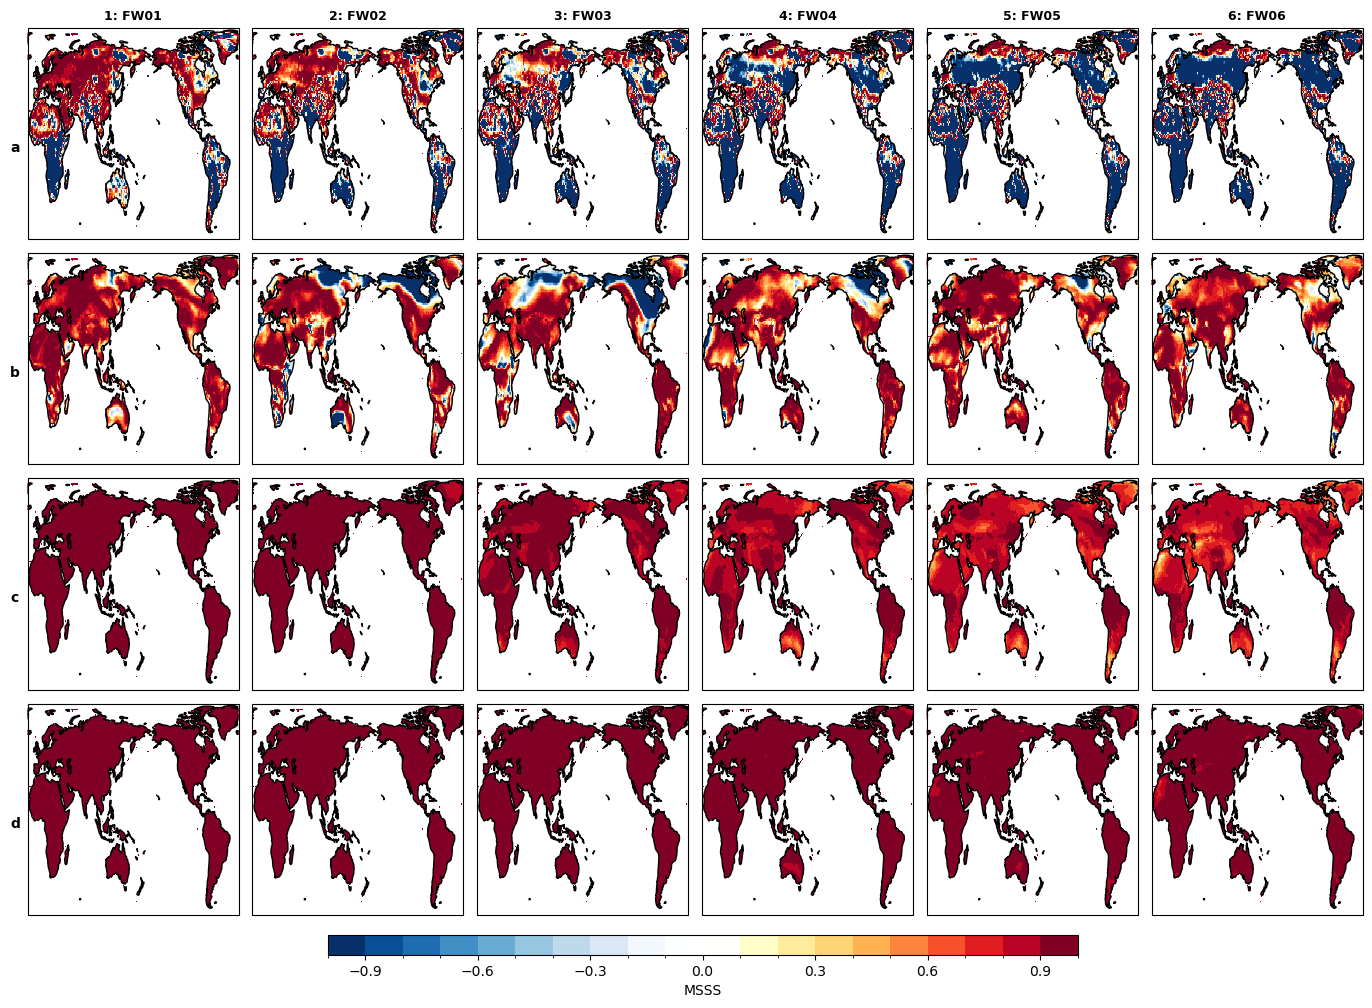

In [52]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=160)

fsize=10
fweight='bold'
cmap = "blue2red"
lon = tas_climobias2_feb8.lon
lat = tas_climobias2_feb8.lat

tmp = msss1_feb8
for i in range(ncols):
    titstr = '{}: FW'.format(i+1)+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(titstr,loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    ax1.set_ylim([-60,85])

tmp = msss3_feb8
#tmp = tas_climobias3_feb8
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax2.text(-210,0,'b',fontsize=10,weight='bold')
    ax2.set_ylim([-60,85])

tmp = msss2_1mem_feb8
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+2*ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax3.text(-210,0,'c',fontsize=10,weight='bold')
    ax3.set_ylim([-60,85])


tmp = msss2_3mem_feb8
#tmp = tas_climobias3_jun21
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    leadstr = 'FW '+str(i+1).zfill(2)
    labstr = 'd'+str(i+1).zfill(2)
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+3*ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax4.text(-210,0,'d',fontsize=10,weight='bold')
    ax4.set_ylim([-60,85])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.1)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig05.png')

## Figure Supplementary 3

In [53]:
%%time
tmp = tas_jun21_wk.rename({'member':'M'}).drop_vars('tas') - tas_climo2_jun21_wk.drop_vars('tas')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom2_jun21_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 40.5 ms, sys: 103 μs, total: 40.6 ms
Wall time: 40.6 ms


In [54]:
%%time
tmp = tas_jun21_wk.rename({'member':'M'}).drop_vars('tas') - tas_climocpc_jun21_wk.drop_vars('tas')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom1_jun21_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 104 ms, sys: 710 μs, total: 105 ms
Wall time: 107 ms


In [55]:
%%time
tmp = tas_jun21_wk.rename({'member':'M'}).drop_vars('tas') - tas_climoic_jun21_wk.drop_vars(['tas','date'])
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom3_jun21_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 42 ms, sys: 160 μs, total: 42.1 ms
Wall time: 49.9 ms


In [56]:
%%time
tmp = tas_jun21_wk.rename({'member':'M'}).drop_vars('tas') - tas_climo2sm_jun21_wk.drop_vars('tas')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom2sm_jun21_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 43.8 ms, sys: 36 μs, total: 43.8 ms
Wall time: 49.3 ms


In [58]:
%%time
tmp = tas_jun21_wk.rename({'member':'M'}).drop_vars('tas') - tas_jun21_wk_resamp1.isel(member=0).drop_vars(['date']).mean('init')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom2_1mem_jun21_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 460 ms, sys: 1.15 ms, total: 461 ms
Wall time: 492 ms


In [59]:
%%time
tmp = tas_jun21_wk.rename({'member':'M'}).drop_vars('tas') - tas_jun21_wk_resamp3.mean('member').drop_vars(['date']).mean('init')
dalist = []
for i in range(6):
    dalist.append(tmp[f'tas{i+1}'].rename('tas'))
tas_anom2_3mem_jun21_wk = xr.concat(dalist,dim=lvalsda).rename({'init':'Y'})

CPU times: user 455 ms, sys: 2.96 ms, total: 458 ms
Wall time: 488 ms


In [60]:
%%time
msss3_jun21 = stat.compute_skillcompare_monthly(tas_anom3_jun21_wk,tas_anom2_jun21_wk,nleads=6,resamp=0,detrend=False)['msss'].load()
msss1_jun21 = stat.compute_skillcompare_monthly(tas_anom1_jun21_wk,tas_anom2_jun21_wk,nleads=6,resamp=0,detrend=False)['msss'].load()
msss2sm_jun21 = stat.compute_skillcompare_monthly(tas_anom2sm_jun21_wk,tas_anom2_jun21_wk,nleads=6,resamp=0,detrend=False)['msss'].load()
msss2_1mem_jun21 = stat.compute_skillcompare_monthly(tas_anom2_1mem_jun21_wk,tas_anom2_jun21_wk,nleads=6,resamp=0,detrend=False)['msss'].load()
msss2_3mem_jun21 = stat.compute_skillcompare_monthly(tas_anom2_3mem_jun21_wk,tas_anom2_jun21_wk,nleads=6,resamp=0,detrend=False)['msss'].load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 721.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 1.06 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large

CPU times: user 11.3 s, sys: 5.38 s, total: 16.7 s
Wall time: 20.3 s


In [61]:
%%time
msss3_jun21 = msss3_jun21.where(landmask)
msss1_jun21 = msss1_jun21.where(landmask)
msss2sm_jun21 = msss2sm_jun21.where(landmask)
msss2_1mem_jun21 = msss2_1mem_jun21.where(landmask).mean('iteration')
msss2_3mem_jun21 = msss2_3mem_jun21.where(landmask).mean('iteration')

CPU times: user 122 ms, sys: 3.89 ms, total: 126 ms
Wall time: 128 ms


CPU times: user 3.84 s, sys: 19.3 ms, total: 3.86 s
Wall time: 4.03 s


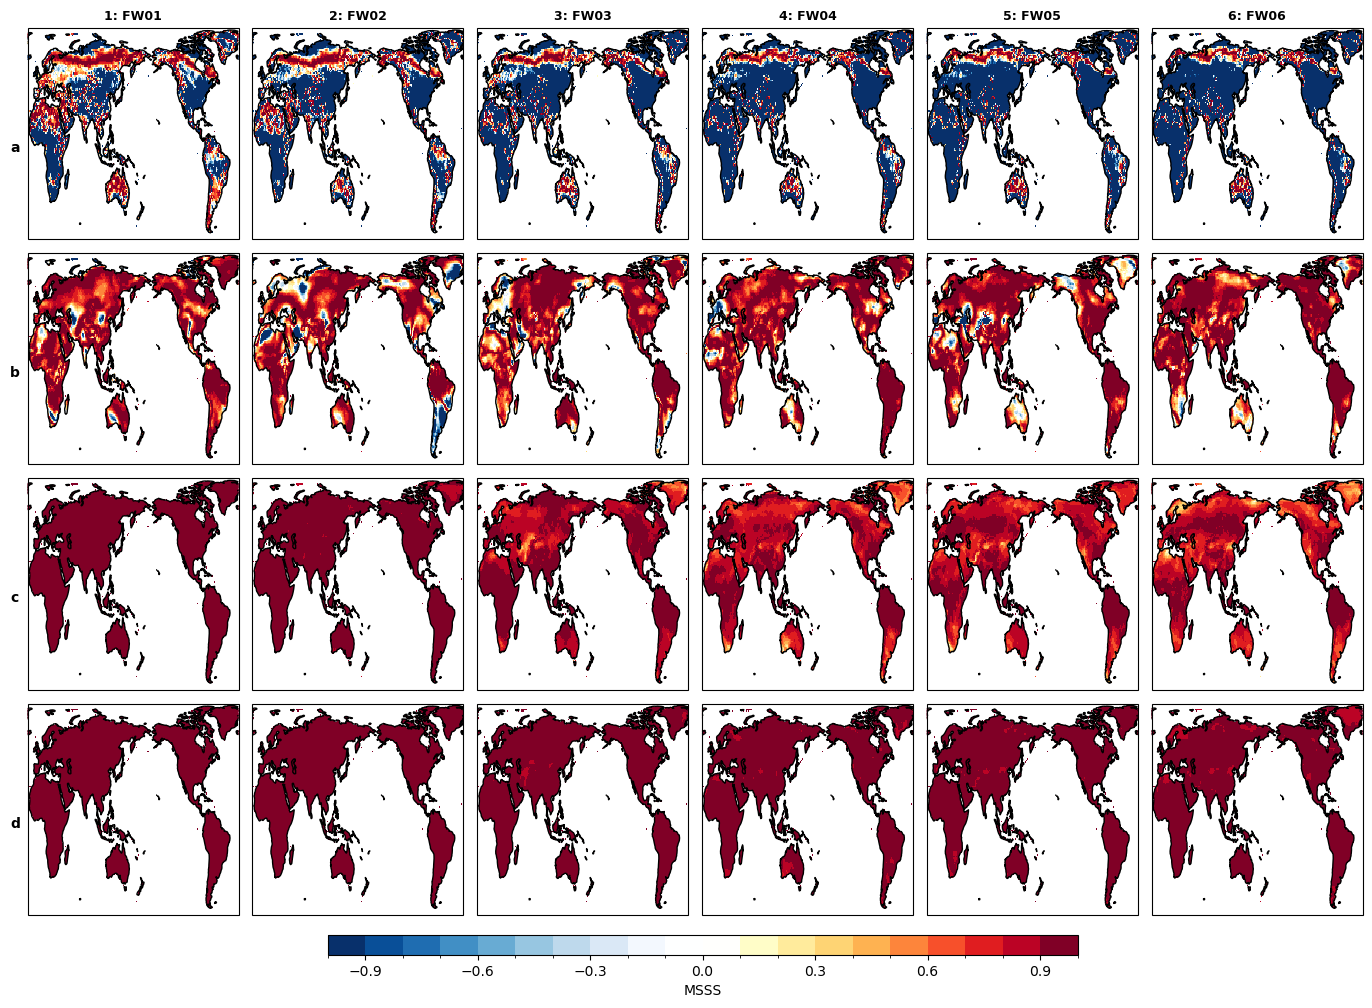

In [62]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=160)

fsize=10
fweight='bold'
cmap = "blue2red"
lon = tas_climobias2_jun21.lon
lat = tas_climobias2_jun21.lat

tmp = msss1_jun21
for i in range(ncols):
    titstr = '{}: FW'.format(i+1)+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(titstr,loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    ax1.set_ylim([-60,85])

tmp = msss3_jun21
#tmp = tas_climobias3_jun21
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax2.text(-210,0,'b',fontsize=10,weight='bold')
    ax2.set_ylim([-60,85])

tmp = msss2_1mem_jun21
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+2*ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax3.text(-210,0,'c',fontsize=10,weight='bold')
    ax3.set_ylim([-60,85])


tmp = msss2_3mem_jun21
#tmp = tas_climobias3_jun21
for i in range(ncols):
    var = 'tas{}'.format(i+1)
    leadstr = 'FW '+str(i+1).zfill(2)
    labstr = 'd'+str(i+1).zfill(2)
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+3*ncols+1,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax4.text(-210,0,'d',fontsize=10,weight='bold')
    ax4.set_ylim([-60,85])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.1)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp03.png')